
## Convolutions

For the discrete convolution, we take a tensor $\textbf{x}$ with $n$ elements and a filter (or kernel) $\textbf{w}$ with $m$ elements, and compute the dot product of the $\textbf{x}$ with a rotated version of $\textbf{w}$
$$
\begin{equation}
\textbf{y} = \textbf{x} * \textbf{w} \to y[i]
\end{equation}
$$

For discrete convolutions, we need to define a padding scheme to add zeros and extend the series. The most common type used in DL is **same** padding, which sets the stride and padding so that the output is the same size/shape as the input.

## Implementing a CNN

In [10]:
# reading an image with pytorch
import torch
from torchvision.io import read_image
img = read_image('../machine-learning-book/ch14/example-image.png')
print('Image shape:', img.shape)
print('Number of channels:', img.shape[0])
print('Image type:', img.dtype)
print(img[:, 100:102, 100:102])

Image shape: torch.Size([3, 252, 221])
Number of channels: 3
Image type: torch.uint8
tensor([[[179, 182],
         [180, 182]],

        [[134, 136],
         [135, 137]],

        [[110, 112],
         [111, 113]]], dtype=torch.uint8)


In [9]:
# Loss functions
#   For binary problems, use binary cross-entropy
#   For multiclass problems, use categorical cross-entropy
# PyTorch can handle either the probabilities, or logits
# though logits are often easier to work with numerically
import torch.nn as nn
logits = torch.tensor([0.8])
probas = torch.sigmoid(logits)
target = torch.tensor([1.0])
# Binary
bce_loss_fn = nn.BCELoss()
bce_logits_loss_fn = nn.BCEWithLogitsLoss()
print(f'BCE (w Probas): {bce_loss_fn(probas, target):.4f}')
print(f'BCE (w Logits): {bce_logits_loss_fn(logits, target):.4f}')
# Categorical
logits = torch.tensor([[1.5, 0.8, 2.1]])
probas = torch.softmax(logits, dim=1)
target = torch.tensor([2])
cce_loss_fn = nn.NLLLoss()
cce_logits_loss_fn = nn.CrossEntropyLoss()
print(f'CCE (w Probas): {cce_loss_fn(torch.log(probas), target):.4f}')
print(f'CCE (w Logits): {cce_logits_loss_fn(logits, target):.4f}')


BCE (w Probas): 0.3711
BCE (w Logits): 0.3711
CCE (w Probas): 0.5996
CCE (w Logits): 0.5996


In [14]:
# Use the MNIST data and train a DL network with
# Input: batch x 28 x 28 x 1
# Convolution: batch x 28 x 28 x 32
# Pooling: batch x 14 x 14 x 32
# Convolution: batch x 14 x 14 x 64
# Pooling: batch x 7 x 7 x 64
# Fully connected: batch x 1024
# Fully connected (and softmax): batch x 10

# Load the data
import torchvision
from torchvision import transforms

image_path = './'
transform = transforms.Compose([
    transforms.ToTensor()
    ])
mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True,
    transform=transform, download=True
)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset,
                             torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset,
                             torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(
    root=image_path, train=False,
    transform=transform, download=False
)

1.0%

100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100.0%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100.0%
100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [15]:
# implement a data loader
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset,
                      batch_size,
                      shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset,
                      batch_size,
                      shuffle=True)

In [16]:
# implement the model

# Part 1: Convolutional and pooling layers
model = nn.Sequential()
model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=1, out_channels=32,
        kernel_size=5, padding=2
    )
)
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5, padding=2
    )
)
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
# at this point, the torch.Size is [batch, 64, 7, 7]

# Part 2: fully connected classifier labels
model.add_module('flatten', nn.Flatten()) # size now [batch, 3136]
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))
# don't need to add a softmax layer because it's implicit in CrossEntropyLoss

# set the loss
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Now we define the model training function
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch, in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (
                torch.argmax(pred, dim=1) == y_batch
            ).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += \
                    loss.item()*y_batch.size(0)
                is_correct = (
                    torch.argmax(pred, dim=1) == y_batch
                ).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: '
              f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
              f'{accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [18]:
# Now train and evaluate the model
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9487 val_accuracy: 0.9824
Epoch 2 accuracy: 0.9842 val_accuracy: 0.9870
Epoch 3 accuracy: 0.9894 val_accuracy: 0.9887
Epoch 4 accuracy: 0.9918 val_accuracy: 0.9877
Epoch 5 accuracy: 0.9930 val_accuracy: 0.9902
Epoch 6 accuracy: 0.9949 val_accuracy: 0.9881
Epoch 7 accuracy: 0.9952 val_accuracy: 0.9903
Epoch 8 accuracy: 0.9965 val_accuracy: 0.9888
Epoch 9 accuracy: 0.9958 val_accuracy: 0.9907
Epoch 10 accuracy: 0.9963 val_accuracy: 0.9886
Epoch 11 accuracy: 0.9972 val_accuracy: 0.9905
Epoch 12 accuracy: 0.9977 val_accuracy: 0.9903
Epoch 13 accuracy: 0.9972 val_accuracy: 0.9904
Epoch 14 accuracy: 0.9981 val_accuracy: 0.9895
Epoch 15 accuracy: 0.9975 val_accuracy: 0.9908
Epoch 16 accuracy: 0.9980 val_accuracy: 0.9897
Epoch 17 accuracy: 0.9978 val_accuracy: 0.9916
Epoch 18 accuracy: 0.9981 val_accuracy: 0.9895
Epoch 19 accuracy: 0.9979 val_accuracy: 0.9909
Epoch 20 accuracy: 0.9988 val_accuracy: 0.9904


Text(0, 0.5, 'Accuracy')

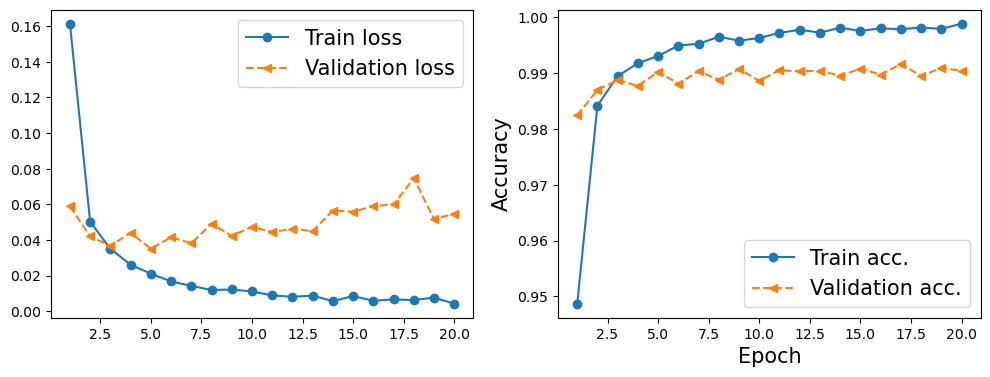

In [22]:
import matplotlib.pyplot as plt
import numpy as np
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<',
        label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

In [23]:
# Now apply the model to the test data
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (
    torch.argmax(pred, dim=1) == mnist_test_dataset.targets
).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9934
